## Loading EMG data
EMF data come from the NinaPro DB7 public database.
<br> We load the full scale data from a number of subjects, extracting data for a number of hand poses (classes). See NinaPro for the correspondance between class ID and actual hand pose/movement. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import pandas as pd
import os

In [8]:

'''
Large scale data
'''
def load_data(subjects, classes, sampling_rate, no_electrodes, extract_features=False):
    '''
    Input:
        - list of subject IDs and classes (hand poses)
    Output
        - emg_labelled: list of lists corresponding to raw EMG for each class (if more than one subject is input, only data of last subject is stored)
        - y holds the classes (hand pose ID) of samples
        - if extract_features=True: extract features from raw EMG and saves features for each electrode over all samples (i.e., subjects and classes) 
          into global_el. if extract_features=False: global_el is empty

    '''
    #alternative paths to file when file is nearby relative to current repository (here we dont have to explicitly define the data_path)
    # script_path = os.path.abspath('EMG_data_SVM_classifier.ipynb') #absolute path to script
    #script_dir = os.path.split(script_path)[0] #absolute path into current directory
    # script_dir = script_dir[:script_dir.rfind('\\')+1] #absolute path into folder one level above the current directory
    # rel_path = 'Data/'+'S'+str(subject)+'_E1_A1.mat' #relative path from folder one level above the current directory to data file
    # abs_file_path = os.path.join(script_dir, rel_path) #absolute path to data file

    #explicit path to data folder
    data_path = 'C:\\Users\\David\\Projects\\Data'

    subjects_labels = [str(s) for s in subjects]
    #target variable stores class ID for each EMG data stream
    y = []
    #initialize empty lists for storing electrode data across samples
    global_el = [[] for i in range(12)]
    for idx, subject in enumerate(subjects):
        #extract data for each subject
        file_name = '\\S'+str(subject)+'_E1_A1.mat' #relative path from current script directory to data file
        abs_file_path = data_path + file_name #absolute path to data file
        #load data from MATLAB file
        mat = (spio.loadmat(abs_file_path, squeeze_me=True))
        #extracts raw emg data
        emg = np.array(mat['emg'])
        # print(np.shape(emg))
        #each time point labelled with corresponding pose
        stimulus = np.array(mat['stimulus'])
        #extract classes (hand poses) from raw emg data 
        emg_labelled = [emg[np.where(stimulus==i)] for i in range(1,len(classes)+1)] #list of lists corresponding to raw EMG for each class
        #data collection time interval in seconds
        time_pose = [len(emg_labelled[c])/sampling_rate for c in range(len(classes))] 

        '''
        Feature Extraction
        '''
        if extract_features is True: #reduces raw EMG into features stored in global_el
            #convert data to freq. domain
            xf, yf = time_to_freq_domain(emg_labelled, time_pose, sampling_rate, classes, no_electrodes)
            # print('L:',np.shape(xf[0]),np.shape(xf[1]),np.shape(xf[2]))
            # print('L:',np.shape(yf[0]),np.shape(yf[1]),np.shape(yf[2]))
            # print(type(xf))
        

            #Mean Power (MP)
            MP = [np.sum(np.abs(yf[c]),axis=1)/len(xf[c]) for c in range(len(classes))]
            # #saves data for each electrode over samples
            el = [[MP[c][e] for c in range(len(classes))] for e in range(no_electrodes)]
            #appends data of current sample to electrode data of all samples
            global_el = [global_el[e] + el[e] for e in range(no_electrodes)]
        
        #target variables (class ID)
        y += classes
        
    

    return emg_labelled, y,time_pose, global_el
    

  - ``global_el`` stores extracted features for each electrode over all of the samples, shape=(no. electrode, no. samples).
 #### Creating a data frame from extractred data

In [11]:
if __name__ == "__main__":

    no_electrodes = 12 #number of electrodes
    sampling_rate = 2000 #Hz
    classes = [3, 5, 6] #how many movement to classify
    subjects = [1,2]#,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] #subjects to extract
    emg_labelled, y,time_pose, global_el = load_data(subjects, classes, sampling_rate, no_electrodes, extract_features=True)
    data = {'El: '+str(e):global_el[e] for e in range(12)}
    data['Class'] = y
    data_X = pd.DataFrame(data)    
    data_X.head()
    data_X.tail()
    #data_X.info()
    #data_X.shape
    display(data_X)



(1797052, 12)
<class 'list'>
(1795164, 12)
<class 'list'>


,El: 0,El: 1,El: 2,El: 3,El: 4,El: 5,El: 6,El: 7,El: 8,El: 9,El: 10,El: 11,Class
0,0.004374,0.003078,0.001381,0.000983,0.000806,0.001193,0.002534,0.006720,0.001142,0.003960,0.000699,0.002077,3
1,0.006472,0.012695,0.002058,0.001186,0.001494,0.002678,0.005526,0.005080,0.001957,0.012974,0.000684,0.002072,5
2,0.007347,0.012464,0.001994,0.001245,0.002646,0.003613,0.006996,0.004973,0.003075,0.009052,0.000690,0.002021,6
3,0.008391,0.004951,0.001121,0.000937,0.001457,0.002312,0.003409,0.003547,0.000933,0.008177,0.000873,0.001924,3
4,0.001645,0.010227,0.001318,0.000974,0.001616,0.004053,0.005298,0.002187,0.001805,0.008532,0.000838,0.002131,5
5,0.006774,0.011423,0.001493,0.001017,0.002752,0.004236,0.006399,0.002209,0.002735,0.008092,0.000818,0.002055,6


In [18]:
#np.shape(emg_labelled[0])

(65641, 12)

#### Sample testing data
We also extract data for a single subjects for the purpose of manual checks, testing and plotting of features.

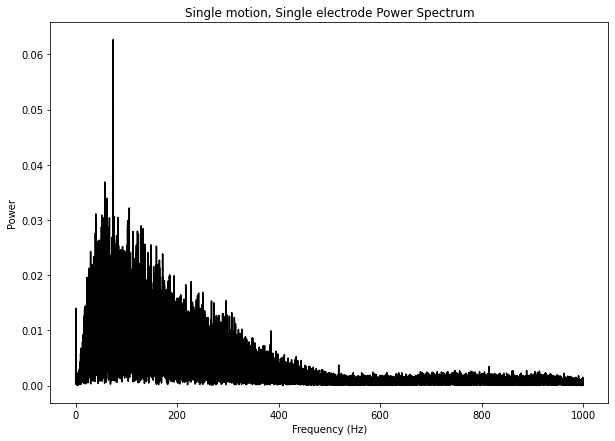

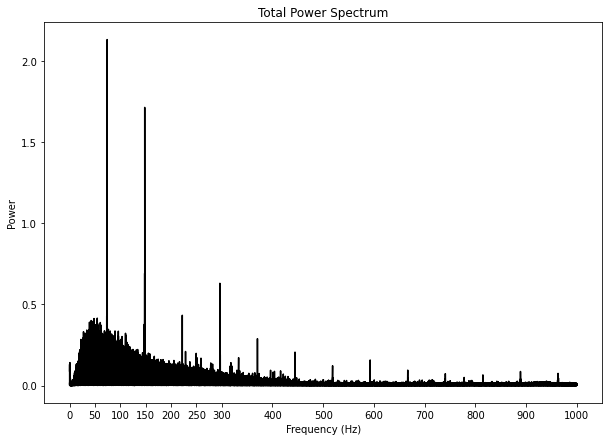

In [19]:
'''
Small scale data
'''   
def sample_data(file_name = 'S11_E1_A1.mat', tot_power=False):
    '''
    Input:
        - single subject data
    Output:
        - can be used to process single subject data
        - can be used to plot EMG channels data
        - if tot_power=True: extract a representative long sample spanning multiple hand poses and rest periods 
          from all electrodes and show its power spectrum. This shows what is the general frequency spectrum of our EMG signals
          for use in filters, etc.
        
    '''
    #explicit path to data folder
    data_path = 'C:\\Users\\David\\Projects\\Data'
    file_name = '\\'+file_name #relative path from current script directory to data file
    abs_file_path = data_path + file_name #absolute path to data file
    #load data from MATLAB file
    mat = (spio.loadmat(abs_file_path, squeeze_me=True))
    emg = np.array(mat['emg']) #raw emg data stream containing all poses and rest
    stimulus = np.array(mat['stimulus']) #each time point labelled with corresponding pose
    emg_pose_1 = emg[np.where(stimulus==1)] #emg signal for pose 1
    no_electrodes = np.shape(emg_pose_1)[1] #number of electrodes
    sampling_rate = 2000 #Hz
    time_pose_1 = len(emg_pose_1)/sampling_rate #data collection time interval in seconds

    #convert to frequency domain
    xf, yf = time_to_freq_domain(emg_pose_1, time_pose_1, sampling_rate, [], no_electrodes, sample=True)
    #Feature Extraction
    MP = [np.sum(np.abs(yf[e])/len(xf)) for e in range(no_electrodes)]

    if tot_power is True: #extract a representative long sample from all electrodes and show its power spectrum
        emg_stream = []
        for e in range(no_electrodes):#concatonate first x samples of each electrode
            emg_stream += emg[:500000,e].tolist()
        time_pose_stream = len(emg_stream)/sampling_rate #data collection time interval in seconds
        #convert to frequency domain
        # Number of samples in EMG sample
        N = int(sampling_rate * time_pose_stream)
        #matrix of fourier transform for each electrode
        yf = rfft(emg_stream)
        xf = rfftfreq(N, 1 / sampling_rate)

        #frequency plot
        fig = plt.figure(figsize=(10,7))
        plt.title('Total Power Spectrum')
        plt.plot(xf, np.abs(yf), color='black') #absolute since yf outputs as complex numbers
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power')
        plt.xticks([0,50,100,150,200,250,300,400,500,600,700,800,900,1000])
        plt.show()
        # fig.savefig('EMG_total_freq_spectrum.svg', format='svg', dpi=1200)

    return emg_pose_1, time_pose_1

if __name__ == "__main__":
    sample_data(file_name = 'S11_E1_A1.mat', tot_power=True)

#### Tranform to Frequency-Domain
- fft() calculates the transform itself.
- fftfreq() calculates the frequencies in the center of each bin in the output of fft(). Without this, there would be no way to plot the x-axis on your frequency spectrum.

In [10]:
#Fast Fourier Transform package
from scipy.fft import rfft, rfftfreq, irfft

def time_to_freq_domain(data, time_pose, sampling_rate, classes, no_electrodes, sample=False):
    '''
    Input:
        - data in time-domain
    Output:
        -  signal coordinates in frequency-domain: xf frequency bins and corresponding yf powers
    '''
    if sample is True: #for single-class data
        # Number of samples in EMG sample
        N = int(sampling_rate * time_pose)
        #matrix of fourier transform for each electrode
        yf = [rfft(data[:,e]) for e in range(no_electrodes)]
        xf = rfftfreq(N, 1 / sampling_rate)
       
        #frequency plot
        fig = plt.figure(figsize=(10,7))
        plt.plot(xf, np.abs(yf[0]), color='black') #absolute since yf outputs as complex numbers
        plt.title('Single motion, Single electrode Power Spectrum')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power')
        plt.show()
        
    else: #for multi-class data
        # Number of samples in EMG sample
        N = [int(sampling_rate * time_pose[c]) for c in range(len(classes))]

        #matrix of fourier transform for each electrode and class
        yf = [[rfft(data[c][:,e]) for e in range(no_electrodes)] for c in range(len(classes))]
        xf = [rfftfreq(N[c], 1 / sampling_rate) for c in range(len(classes))]

    
    return xf, yf